<a href="https://colab.research.google.com/github/jiku100/2020-2-machine-running-proejct/blob/master/assignment11/%EC%8B%A0%EC%84%9D%EA%B2%BD_assignment_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification for Multiple Categories using Pytorch for best accuracy with CNN**



# 1. Import library
<hr>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다:", device)

다음 기기로 학습합니다: cuda


# 2. Preprocessing Data
<hr>

In [3]:
transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(20),
        transforms.Normalize((0.1307,),(0.3081,))                    # 이미지를 텐서로 변형합니다.
])

transform_test = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,),(0.3081,))            
])

In [4]:
data_path = './MNIST'

data_test   = datasets.MNIST(root = data_path, train= True, download=True, transform= transform_test)
data_train  = datasets.MNIST(root = data_path, train= False, download=True, transform= transform_train)

type of one image <class 'torch.Tensor'>
size of one image :  torch.Size([1, 28, 28])
type of label :  <class 'int'>
label :  7
255


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


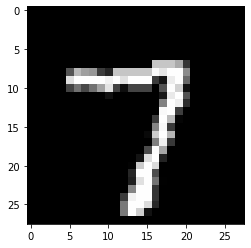

In [5]:
one_image, label = data_train[0]
print("type of one image", type(one_image))
print("size of one image : ", one_image.shape)
plt.imshow(one_image.squeeze().numpy(), cmap='gray')
print("type of label : ", type(label))
print("label : ", label)
print(np.max(data_train.train_data[0].view(-1).numpy()))

In [6]:
learning_rate = 0.003
training_epochs = 600
batch_size = 32
drop_prob = 0.4

In [7]:
train_loader = DataLoader(dataset = data_train, batch_size = batch_size, num_workers = 2, shuffle = True) ## batch size 32 짜리 train loader 생성
test_loader = DataLoader(dataset = data_test, batch_size = batch_size, num_workers = 2, shuffle = True) ## batch size 32 짜리 test loader 생성

# 3. Define Model
<hr>

In [8]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )
        
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

In [9]:
model = classification().to(device)

In [10]:
criterion = nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 4. Training
<hr>

In [11]:
total_batch= len(train_loader)

In [12]:
print(total_batch)

313


In [13]:
def accuracy(log_pred, y_true):
    y_pred = torch.argmax(log_pred, dim=1)
    return (y_pred == y_true).to(torch.float).mean()

In [14]:
def training(model, loss, optim, training_epochs, train_loader, test_loader):
  L_iters_train = []
  accuracy_train = []
  L_iters_test = []
  accuracy_test = []
  for epoch in range(training_epochs):
    total_cost_train = 0
    total_cost_test = 0
    total_acc_train = 0
    total_acc_test = 0
    model.train()
    for X, Y in train_loader:
      X = X.to(device)
      Y = Y.to(device)

      optim.zero_grad()
      train_pred = model(X)
      cost = loss(train_pred, Y)
      cost.backward()
      optim.step()

      total_cost_train += cost
      total_acc_train += accuracy(train_pred, Y)
      
    avg_cost_train = total_cost_train / len(train_loader)
    avg_acc_train = total_acc_train / len(train_loader)

    L_iters_train.append(avg_cost_train)
    accuracy_train.append(avg_acc_train)
    model.eval()
    with torch.no_grad():
      for X_test, Y_test in test_loader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)
        test_pred = model(X_test)
        cost_test = loss(test_pred, Y_test)
        total_cost_test += cost_test
        total_acc_test += accuracy(test_pred, Y_test)
      avg_cost_test = total_cost_test / len(test_loader)
      avg_acc_test = total_acc_test / len(test_loader)
    
      accuracy_test.append(avg_acc_test)
      L_iters_test.append(avg_cost_test)

    print("Epoch: %02d Training Loss: %.9f Testing Loss: %.9f  Training Acc: %.9f Testing Acc: %.9f" %((epoch + 1),avg_cost_train, avg_cost_test, avg_acc_train, avg_acc_test))
  return L_iters_train, accuracy_train, L_iters_test, accuracy_test

In [15]:
L_train, A_train, L_test, A_test = training(model, criterion, optimizer, training_epochs, train_loader, test_loader)

Epoch: 01 Training Loss: 0.688236475 Testing Loss: 0.116430476  Training Acc: 0.799221218 Testing Acc: 0.966516674
Epoch: 02 Training Loss: 0.326885939 Testing Loss: 0.091662206  Training Acc: 0.904452860 Testing Acc: 0.973216653
Epoch: 03 Training Loss: 0.250883192 Testing Loss: 0.089749351  Training Acc: 0.927915335 Testing Acc: 0.974866688
Epoch: 04 Training Loss: 0.224625677 Testing Loss: 0.080781631  Training Acc: 0.936301887 Testing Acc: 0.976333320
Epoch: 05 Training Loss: 0.200676933 Testing Loss: 0.062062290  Training Acc: 0.943690062 Testing Acc: 0.981583357
Epoch: 06 Training Loss: 0.192560792 Testing Loss: 0.063517228  Training Acc: 0.944688499 Testing Acc: 0.981566668
Epoch: 07 Training Loss: 0.168564737 Testing Loss: 0.063022085  Training Acc: 0.953075051 Testing Acc: 0.981316686
Epoch: 08 Training Loss: 0.169780388 Testing Loss: 0.063025989  Training Acc: 0.952376187 Testing Acc: 0.982333362
Epoch: 09 Training Loss: 0.159585387 Testing Loss: 0.061976437  Training Acc: 0.

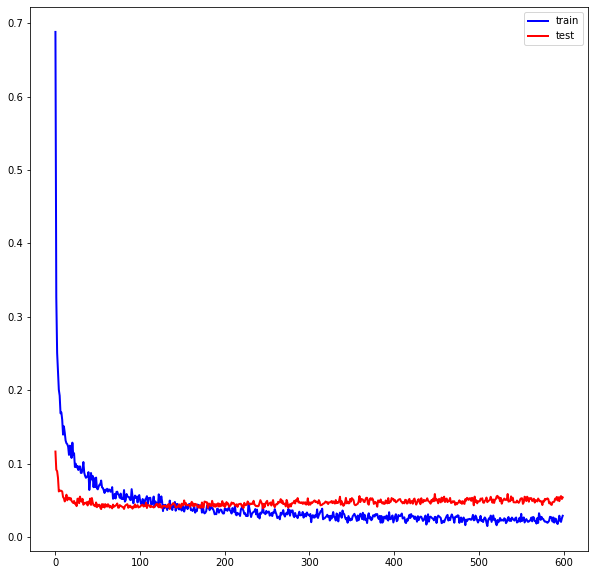

In [16]:
plt.figure(figsize = (10,10))
plt.plot(L_train, linewidth = 2, c='b', label = "train")
plt.plot(L_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

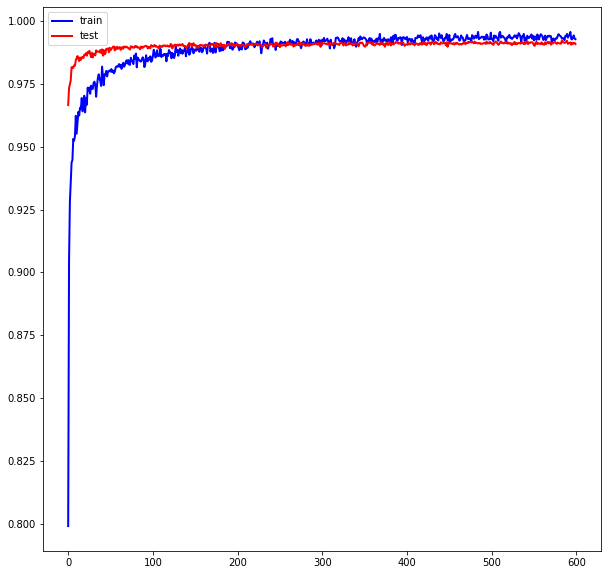

In [17]:
plt.figure(figsize = (10,10))
plt.plot(A_train, linewidth = 2, c='b', label = "train")
plt.plot(A_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

In [18]:
print("training loss    %.2f" %(L_train[-1]))
print("testing loss     %.2f" %(L_test[-1]))
print("training acc    %.2f" %(A_train[-1]))
print("testing acc     %.2f" %(A_test[-1]))

training loss    0.03
testing loss     0.05
training acc    0.99
testing acc     0.99


# 5. Output
<hr>

## 1. Plot the training and testing losses over epochs

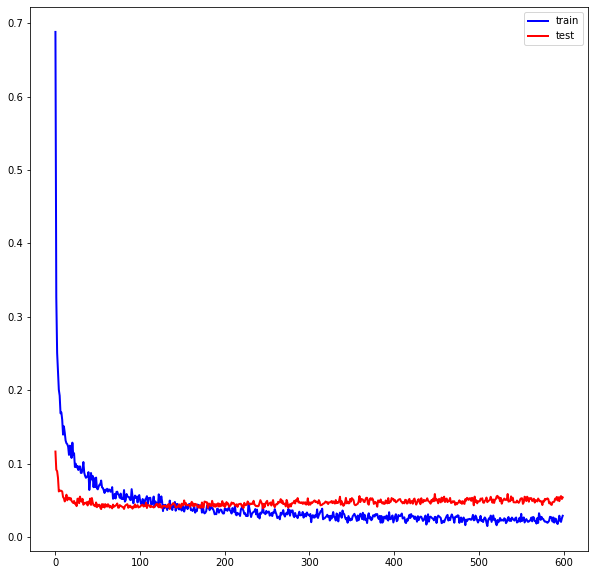

In [19]:
plt.figure(figsize = (10,10))
plt.plot(L_train, linewidth = 2, c='b', label = "train")
plt.plot(L_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

## 2. Plot the training and testing accuracies over epochs

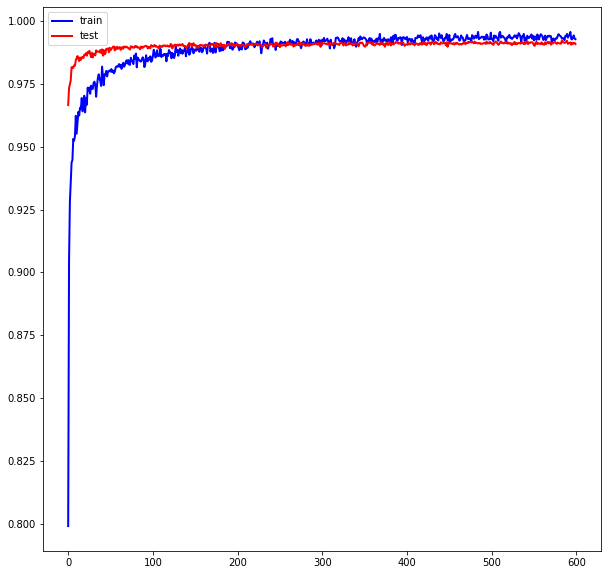

In [20]:
plt.figure(figsize = (10,10))
plt.plot(A_train, linewidth = 2, c='b', label = "train")
plt.plot(A_test, linewidth = 2, c='r', label = "test")
plt.legend()
plt.show()

## 3.  Print the final training and testing losses at convergence 

In [21]:
print("loss")
print("train    %.2f" %(L_train[-1]))
print("test     %.2f" %(L_test[-1]))

loss
train    0.03
test     0.05


## 4. Print the final training and testing accuracies at convergence

In [23]:
print("Accuracy")
print("train    %.5f, %.2f" %(A_train[-1], A_train[-1]))
print("test     %.5f, %.2f" %(A_test[-1], A_test[-1]))

Accuracy
train    0.99271, 0.99
test     0.99077, 0.99


## 5. Print the testing accuracies within the last 10 epochs

In [30]:
for i in range(-10, 0):
  print(f"Epoch = {len(A_test) + i + 1} Acc: %.5f" %(A_train[i]))


Epoch = 591 Acc: 0.99331
Epoch = 592 Acc: 0.99401
Epoch = 593 Acc: 0.99461
Epoch = 594 Acc: 0.99561
Epoch = 595 Acc: 0.99281
Epoch = 596 Acc: 0.99261
Epoch = 597 Acc: 0.99351
Epoch = 598 Acc: 0.99421
Epoch = 599 Acc: 0.99291
Epoch = 600 Acc: 0.99271
